<a href="https://www.kaggle.com/code/omarelhakim0/eeg-emotion-classification-on-seediv?scriptVersionId=282260894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [153]:
!pip install torch_scatter torcheeg torch_geometric -qq

In [154]:
# !rm -rf tmp_out

In [155]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
from torch.utils.data import DataLoader, Subset
from torcheeg.models import CCNN
from torcheeg import transforms
from torcheeg.transforms import ToGrid
from torcheeg.datasets import SEEDIVDataset,SEEDIVFeatureDataset
from torcheeg.datasets.constants import SEED_IV_CHANNEL_LOCATION_DICT
from torcheeg.transforms import ToG
from torcheeg.datasets.constants import SEED_IV_ADJACENCY_MATRIX
from torcheeg.models import DGCNN
import torch_geometric.loader as geom_loader # Special loader for graphs
import copy
import scipy.signal as signal
import random

In [156]:
# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [157]:
def BandPassFilter(eeg_data):
    b, a = signal.butter(4, Wn=[1.0, 75.0], btype='bandpass', fs=200)
    return signal.filtfilt(b, a, eeg_data, axis=-1)

In [158]:
def Notch(eeg_data):
    b, a = signal.iirnotch(w0=50.0, Q=30.0, fs=200)
    return signal.filtfilt(b, a, eeg_data, axis=-1)

In [159]:
# 2. Define Preprocessing
t_transform = transforms.Compose([
    transforms.Lambda(BandPassFilter),
    transforms.Lambda(Notch),
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d()
    
])

In [160]:
def map_emotions(y):
    # Input y is 0, 1, 2, or 3
    if y == 0: 
        return 0  # Neutral remains 0
    elif y == 1 or y == 2: 
        return 1  # Sad (1) and Fear (2) become Negative (1)
    elif y == 3: 
        return 2  # Happy (3) becomes Positive (2)
    return 0

In [161]:
dataset = SEEDIVFeatureDataset(
    io_path='./tmp_out/seed_iv_features',
    root_path='/kaggle/input/seed-iv/eeg_feature_smooth',
    feature=['de_LDS'], 
    num_worker=0,
    offline_transform=transforms.Compose([
        # FIX: Use To2d to get a Tensor (Electrodes, Features)
        # We don't need ToGrid (Images) or ToG (Graphs)
        transforms.To2d(), 
        transforms.Lambda(lambda x: torch.tensor(x).float())    ]),
    label_transform=transforms.Compose([
        transforms.Select('emotion'),
        transforms.Lambda(map_emotions)
    ])
)

[2025-11-27 17:44:14] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./tmp_out/seed_iv_features.


In [162]:
import pandas as pd

# 1. Get the metadata DataFrame
df = dataset.info

# 2. Count the segments for each emotion
# 0: Neutral, 1: Sad, 2: Fear, 3: Happy
counts = df['emotion'].value_counts().sort_index()
total = len(df)

print(f"Total Segments: {total}")
print("-" * 30)
print("Count per Emotion:")
print(counts)

print("-" * 30)
print("Percentage per Emotion:")
percentages = (counts / total) * 100
print(percentages.round(2))

# 3. Check for Imbalance
# If the difference between max and min is > 10%, we might need a WeightedSampler
max_pct = percentages.max()
min_pct = percentages.min()

if (max_pct - min_pct) > 10:
    print(f"\n⚠️ WARNING: Data is IMBALANCED (Diff: {max_pct - min_pct:.2f}%)")
    print("Consider using a WeightedRandomSampler.")
else:
    print(f"\n✅ Data is reasonably BALANCED (Diff: {max_pct - min_pct:.2f}%)")

Total Segments: 37575
------------------------------
Count per Emotion:
emotion
0    10170
1    10245
2     9225
3     7935
Name: count, dtype: int64
------------------------------
Percentage per Emotion:
emotion
0    27.07
1    27.27
2    24.55
3    21.12
Name: count, dtype: float64

✅ Data is reasonably BALANCED (Diff: 6.15%)


In [163]:
# Split by Trial ID
# SEED-IV has 24 trials (videos) per session.
# 80% of VIDEOS for training (19 videos), 20% for testing (5 videos).
all_trial_ids = list(range(1, 25))

random.seed(42)
test_trial_ids = random.sample(all_trial_ids, 5)
train_trial_ids = [t for t in all_trial_ids if t not in test_trial_ids]

train_indices = df[df['trial_id'].isin(train_trial_ids)].index.tolist()
test_indices = df[df['trial_id'].isin(test_trial_ids)].index.tolist()

# Create Subsets & Loaders
train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [164]:
model = DGCNN(
    in_channels=5,      # 5 Frequency Bands
    num_electrodes=62, 
    num_layers=2,       # Standard depth
    hid_channels=32,
    num_classes=3,
).to(device)

# Add weights to classes
weights = torch.tensor([1.0, 0.8, 1.8]).to(device)
weights = weights / weights.sum() * 3.0

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)
# Scheduler: If validation loss doesn't go down for 3 epochs, cut LR by half
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [165]:

# Early Stopping
patience = 15
counter = 0
best_val_acc = 0.0
best_model_state = None

for epoch in range(100):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        X, y = batch
        X = X.squeeze(1)
        X = X.to(device)
        y = y.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    train_acc = 100 * correct / total
    
    # --- VALIDATION ---
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            X, y = batch
            
            # Same shape logic for validation
            X = X.squeeze(1)
            if X.shape[-1] == 62:
                X = X.transpose(1, 2)
            
            X = X.to(device)
            y = y.to(device).long()
            
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += y.size(0)
            val_correct += (predicted == y).sum().item()
            
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}% | Val Loss={avg_val_loss:.4f}")

    # --- EARLY STOPPING ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_dgcnn_final.pth')
        print(f"  --> New Best! {best_val_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("  --> Early Stopping.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Finished. Best Acc: {best_val_acc:.2f}%")

Epoch 1: Train Acc=63.23% | Val Acc=52.77% | Val Loss=1.0608
  --> New Best! 52.77%
Epoch 2: Train Acc=75.60% | Val Acc=62.81% | Val Loss=0.9961
  --> New Best! 62.81%
Epoch 3: Train Acc=79.86% | Val Acc=72.45% | Val Loss=0.9330
  --> New Best! 72.45%
Epoch 4: Train Acc=83.03% | Val Acc=57.50% | Val Loss=1.0072
Epoch 5: Train Acc=84.92% | Val Acc=62.60% | Val Loss=0.9942
Epoch 6: Train Acc=85.70% | Val Acc=73.36% | Val Loss=0.9093
  --> New Best! 73.36%
Epoch 7: Train Acc=86.88% | Val Acc=73.93% | Val Loss=0.9138
  --> New Best! 73.93%
Epoch 8: Train Acc=88.32% | Val Acc=57.99% | Val Loss=1.0579
Epoch 9: Train Acc=88.64% | Val Acc=68.17% | Val Loss=0.9354
Epoch 10: Train Acc=89.00% | Val Acc=69.39% | Val Loss=0.9459
Epoch 11: Train Acc=91.29% | Val Acc=67.34% | Val Loss=0.9707
Epoch 12: Train Acc=92.12% | Val Acc=68.77% | Val Loss=0.9485
Epoch 13: Train Acc=92.26% | Val Acc=66.37% | Val Loss=0.9465
Epoch 14: Train Acc=92.22% | Val Acc=70.23% | Val Loss=0.9386
Epoch 15: Train Acc=93.48%

Generating confusion matrix...


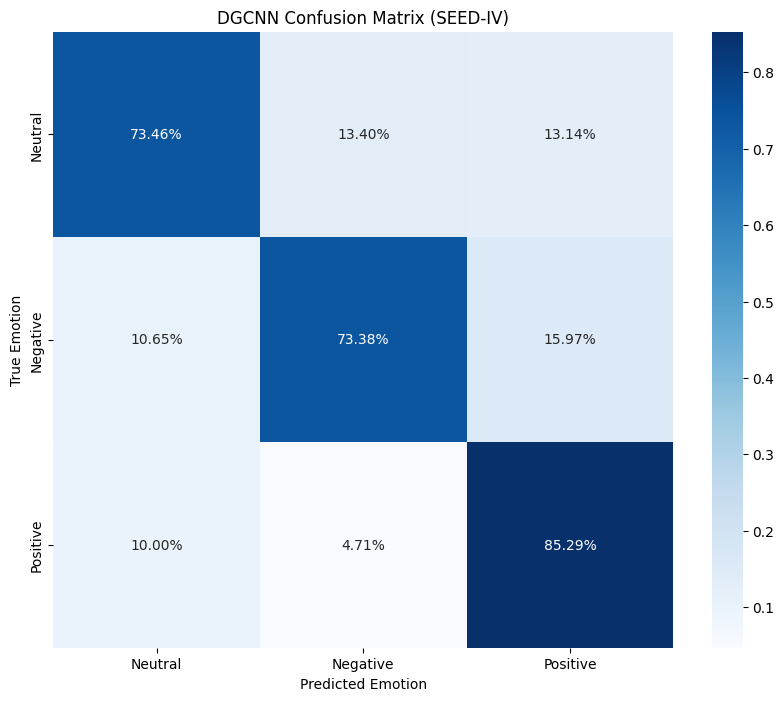

              precision    recall  f1-score   support

     Neutral       0.81      0.73      0.77      3120
    Negative       0.86      0.73      0.79      4020
    Positive       0.45      0.85      0.59      1020

    accuracy                           0.75      8160
   macro avg       0.71      0.77      0.72      8160
weighted avg       0.79      0.75      0.76      8160



In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Get Predictions for the entire Test Set
model.eval()
y_true = []
y_pred = []

print("Generating confusion matrix...")

with torch.no_grad():
    for batch in test_loader:
        X, y = batch
        
        # Apply the same Shape Fix logic
        X = X.squeeze(1)
        if X.shape[-1] == 62:
             X = X.transpose(1, 2)
             
        X = X.to(device)
        y = y.to(device)
        
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 2. Define Emotion Labels
# 0: Neutral, 1: Sad, 2: Fear, 3: Happy
emotion_labels = ['Neutral', 'Negative', 'Positive']

# 3. Create Matrix
cm = confusion_matrix(y_true, y_pred)
# Normalize it to show Percentages instead of raw numbers
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('DGCNN Confusion Matrix (SEED-IV)')
plt.show()

# 5. Print Detailed Report
print(classification_report(y_true, y_pred, target_names=emotion_labels))